# TACHE 9 : ph_dos

Dans ce notebook, nous allons calculer les températures de Debye $\theta_D$ et d'Einstein $\theta_E$ telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique du SrCN₂. De plus, nous représenterons les trois courbes de chaleur spécifique, celle correspondant à l'objet téléchargé ainsi que celles obtenues à partir des modèles de Debye et d'Einstein. Finalement, nous représenterons les trois densités d'états de phonons correspondantes.


In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import integrate as intg
from matplotlib import pyplot as plt
from IPython.display import Image

In [2]:
mp_key = "hGFJONMWFhZMzX55ulNNTvmOkGE07nJS"
mp_id = "mp-12317"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Densité d'états de phonons du SrCN₂

Le graphe ci-dessous représente la fréquence en THz en fonction de la densité d'état de phonons du SrCN₂. 

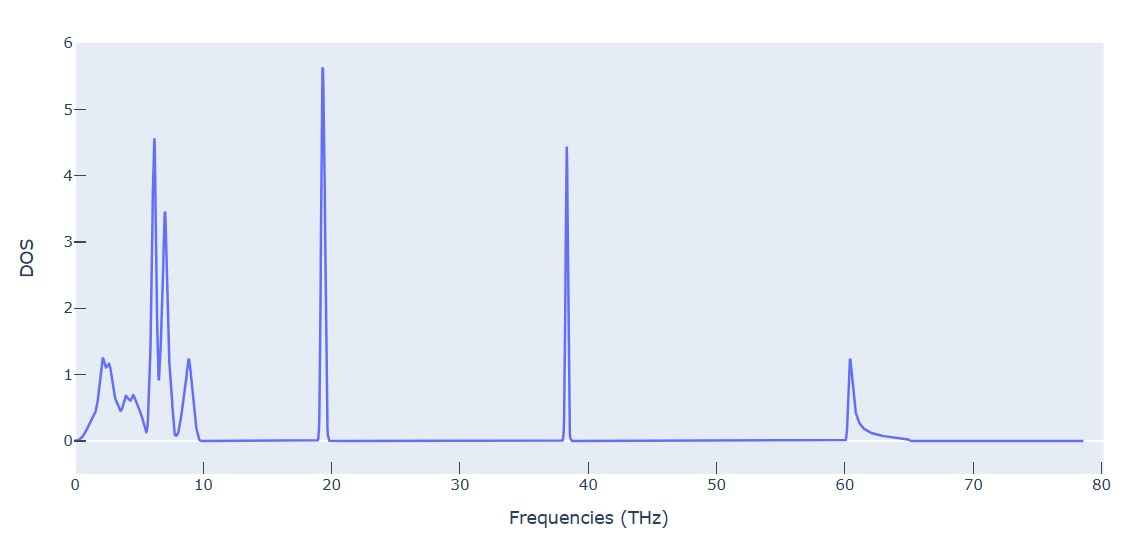

In [4]:
fig_ph_dos = get_plot_dos(ph_dos)
fig_ph_dos.update_yaxes(range=[-0.5, 6])
#fig_ph_dos.show()
display(Image(filename="freq_dos.jpg"))

Le graphe ci-dessous représente le vecteur d'onde ainsi que la densité d'état de phonons en fonction de la fréquence.

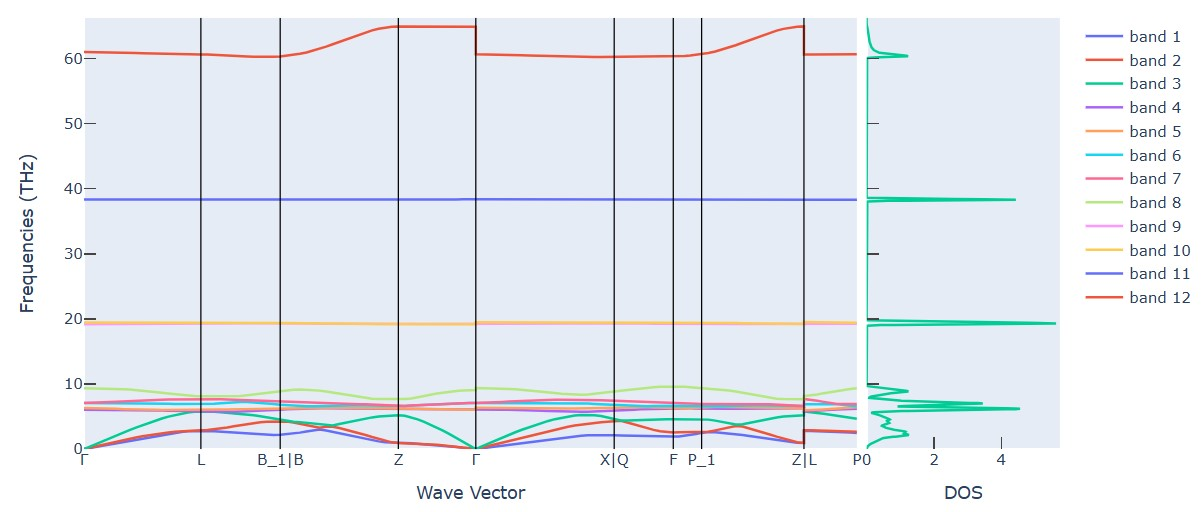

In [5]:
fig_ph_bs_and_dos = get_plot_bs_and_dos(ph_bs, ph_dos)
#fig_ph_bs_and_dos.show()
display(Image(filename="vect_freq_dos.jpg"))

## Chaleurs spécifiques

La chaleur spécifique peut être représentée selon deux modèles, celui d'Einstein et celui de Debye. Ces deux modèles ne prennent pas en compte les relations de dispersion $\omega_q (q)$.

### Modèle d'Einstein : 

Le modèle d'Einstein fait l'hypothèse que toutes les fréquences $\omega_q (q)$ sont égales à une fréquence naturelle de vibration $\omega_E$ : $\omega_q (q)$ = $\omega_E$.<br>

La température d'Einstein est définie par la relation : \$$k_B \theta_E = \hbar \omega_E$$
        avec la constante de Boltzmann $k_B = 1.380649e^{-23}$ J/K,
             la température d'Einstein $\theta_E$ $[K]$,
             la constante de Planck réduite $\hbar = 1.0545718e^{−34} Js$
             et la fréquence naturelle de vibration $\omega_E$ $[rad/s]$.

La chaleur spécifique molaire selon le modèle d'Einstein s'écrit : $$C_V = 3 N R \left( \frac{\theta_E}{T} \right)^2 \frac{e^{\theta_E / T}}{\left( e^{\theta_E / T} - 1 \right)^2}$$


In [6]:
#Constantes
N_at = len(prim_struc) #Nombre d'atomes
R = 8.314 #[J/molK]

In [8]:
#Extraction des données pour Cv/3NR
temperature = np.array(np.arange(0, 1000, 5))
ph_cv = np.array([ph_dos.cv(temperature[i]) for i in range(len(temperature))])/(3*N_at*R)

In [9]:
temp = np.array(np.arange(1, 1000, 1))

#Retourne Cv/3N*R pour le modèle d'Einstein
def Cv_Einstein(T, T_E):
    return (T_E / T) ** 2 * np.exp(T_E / T) / (np.exp(T_E / T) - 1) ** 2

#Minimisation aux moindres carrés
min_squared_error_E_global = 0
T_E_optimized = 0
for i in range(len(temp)) : 
    min_squared_error_E = 0
    T_E = float(temp[i])
    for j in range(1, len(temperature)):
        Cv_E = Cv_Einstein(float(temperature[j]), T_E)
        min_squared_error_E += (float(ph_cv[j]) - Cv_E) ** 2
    
    if i == 0:
        min_squared_error_E_global = min_squared_error_E
        T_E_optimized = T_E
    
    elif min_squared_error_E <= min_squared_error_E_global :
        min_squared_error_E_global = min_squared_error_E
        T_E_optimized = T_E
print("Température d'Einstein = " +  str(T_E_optimized) + "K")

Température d'Einstein = 516.0K


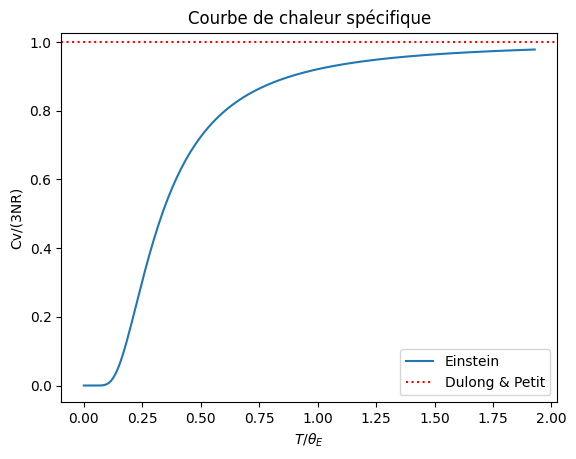

In [11]:
Cv_E_optimized = []

for i in range(len(temperature)) :
    if i == 0 :
        Cv_E_optimized.append(0)
    else :
        Cv_E_optimized.append(Cv_Einstein(float(temperature[i]), T_E_optimized))

plt.plot(temperature/T_E_optimized, Cv_E_optimized,  label='Einstein')
plt.axhline(y=1, color='red',label='Dulong & Petit', linestyle= 'dotted')
plt.xlabel(r'$T / \theta_E$')
plt.ylabel("Cv/(3NR)")
plt.title("Courbe de chaleur spécifique")
plt.legend()
plt.show()

A haute température, la chaleur spécifique tend vers $3NR$ alors que pour de faibles températures ce modèle suit une loi exponentielle : 
$$T >> \theta_E, C_v -> 3NR$$ 
$$T<< \theta_E, C_v \propto e^{-\theta_E / T}$$


### Modèle de Debye

Le modèle de Debye fait l'hypothèse que toutes les fréquences $\omega_\sigma (q)$ ont la même dispersion linéaire : $$\omega_\sigma (q) = vq $$ avec $v$ $[m/s]$ la vitesse de phase et $q$ $[1/m]$ le vecteur d'onde. La fréquence de Debye $\omega_D$ $[rad/s]$ est associée au vecteur d'onde de Debye $q_D$.<br>
La température de Debye est définie par la relation : \$$k_B \theta_D = \hbar \omega_D = \hbar v q_D$$
avec la constante de Boltzmann $k_B = 1.380649e^{-23}$ J/K,
             la température de Debye $\theta_D$ $[K]$,
             la constante de Planck réduite $\hbar = 1.0545718e^{−34} Js$.
En effectuant le changement de variable $x = \hbar v q / k_B T$, la chaleur spécifique molaire selon le modèle de Debye s'écrit : $$C_V = 9 N R \left( \frac{T}{\theta_D} \right)^3 \int_0^{\theta_D / T} \frac{x^4 e^x}{(e^x - 1)^2} \,dx$$

In [12]:
min_squared_error_D_global = 0
T_D_optimized = 0
temp = np.array(np.arange(1, 1000, 1))

#Retourne Cv/3N*R pour le modèle de Debye
def integr(x):
    return x**4 * np.exp(x) / (np.exp(x) - 1) ** 2

def Cv_Debye(T, T_D):
    integrale = float(intg.romberg(integr, 0.000000000000001, T_D/T))
    return 3*(T/T_D)**3 * integrale

#Minimisation aux moindres carrés
for i in range(len(temp)) : 
    min_squared_error_D = 0

    T_D = float(temp[i])
    for j in range(1, len(temperature)):
        Cv_D = Cv_Debye(float(temperature[j]), T_D)
        min_squared_error_D += (float(ph_cv[j]) - Cv_D) ** 2
    
    if i == 0:
        min_squared_error_D_global = min_squared_error_D
        T_D_optimized = T_D
    
    elif min_squared_error_D <= min_squared_error_D_global :
        min_squared_error_D_global = min_squared_error_D
        T_D_optimized = T_D

print("Température de Debye = " + str(T_D_optimized) + "K")

Température de Debye = 710.0K


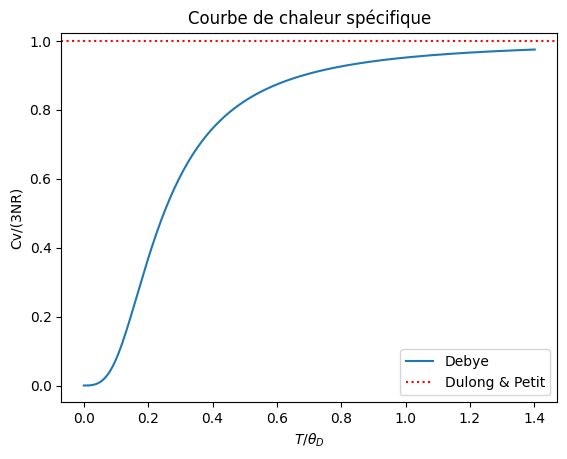

In [13]:
Cv_D_optimized = []

for i in range(len(temperature)) :
    if i == 0 :
        Cv_D_optimized.append(0)
    else :
        Cv_D_optimized.append(Cv_Debye(float(temperature[i]), T_D_optimized))

plt.plot((temperature/T_D_optimized), Cv_D_optimized, label='Debye')

plt.axhline(y=1, color='red',label='Dulong & Petit', linestyle= 'dotted')
plt.xlabel(r'$T / \theta_D$')
plt.ylabel("Cv/(3NR)")
plt.title("Courbe de chaleur spécifique")
plt.legend()
plt.show()


Nous remarquons qu'à haute température la chaleur spécifique tend vers $3NR$ alors que pour de faible température ce modèle suit une loi en $T^3$ : 
$$T >> \theta_D, C_v -> 3NR$$ 
$$T<< \theta_D, C_v \propto T^3$$

### Courbes de chaleur spécifique

Le graphe ci-dessous permet de comparer les modèles d'Einstein et de Debye avec la courbe théorique de chaleur spécifique du SrCN₂.<br>
Il est facile de remarquer que pour ce cristal les modèles approximent mal la chaleur spécifique. En effet, ces deux modèles approximent correctement la courbe de chaleur spécifique de la plupart des matériaux mais, nous remarquons par ce graphe, que ce n'est pas le cas du cristal SrCN₂.<br>

Le modèle d’Einstein suppose des vibrations indépendantes à une fréquence unique, tandis que le modèle de Debye prend en compte une distribution de fréquences. Cependant, pour le SrCN₂, ni l’un ni l’autre ne parviennent à reproduire précisément la chaleur spécifique mesurée. Cela peut être dû à des effets comme la structure cristalline complexe ou l'anisotropie des vibrations.

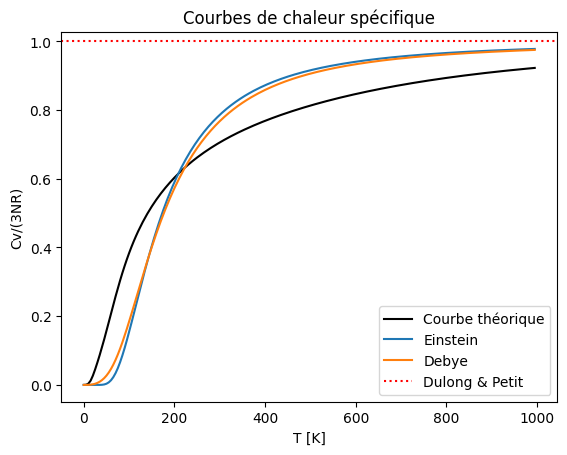

In [15]:
Cv_E_optimized = []
Cv_D_optimized = []

for i in range(len(temperature)) :
    if i == 0 :
        Cv_E_optimized.append(0)
        Cv_D_optimized.append(0)
    else :
        Cv_E_optimized.append(Cv_Einstein(float(temperature[i]), T_E_optimized))
        Cv_D_optimized.append(Cv_Debye(float(temperature[i]), T_D_optimized))

for i in range(len(temperature)) :
    temperature[i] = float(temperature[i])
    ph_cv[i] = float(ph_cv[i])

plt.plot(temperature, ph_cv,color='black', label='Courbe théorique')
plt.plot(temperature, Cv_E_optimized,  label='Einstein')
plt.plot(temperature, Cv_D_optimized, label='Debye')

plt.axhline(y=1, color='red',label='Dulong & Petit', linestyle= 'dotted')
plt.xlabel('T [K]')
plt.ylabel("Cv/(3NR)")
plt.title("Courbes de chaleur spécifique")
plt.legend()
plt.show()

## Densité d'états

La densité d'états des phonons représente les différents modes de vibrations accessibles pour une fréquence donnée. La densité de modes normaux est normalisée de telle sorte que: $$\int g(\omega) \, d\omega = 3N$$ 

Dans le modèle d'Einstein, la densité d'états est un delta de Dirac piqué en $\omega_E$. En effet, le modèle d'Einstein fait l'hypothèse que toutes les fréquences $\omega_q (q)$ sont égales à une fréquence naturelle de vibration $\omega_E$.
$$g_E (\omega) = 3 N \delta(\omega - \omega_E)$$

Dans le modèle de Debye, la densité de modes normaux est une fonction parabolique de la fréquence telle que : 
$$
    g_D (\omega) = \begin{cases} 
        \frac{3 N \Omega \omega^2}{2 \pi^2 v^3}, & \text{si } \omega < \omega_D = v q_D \\
        0, & \text{si } \omega > \omega_D
    \end{cases}
$$
avec $N$ le nombre d'atomes de la cellule unité, $\Omega$ le volume de la maille primitive (en $m^3$), $v$ la vitesse de phase $[m/s]$, $\omega$ la fréquence considérée $[rad/s]$, $q_D = (\frac{6 \pi^2}{\Omega})^{(1/3)}$ $[1/m]$ le vecteur d'onde de Debye.

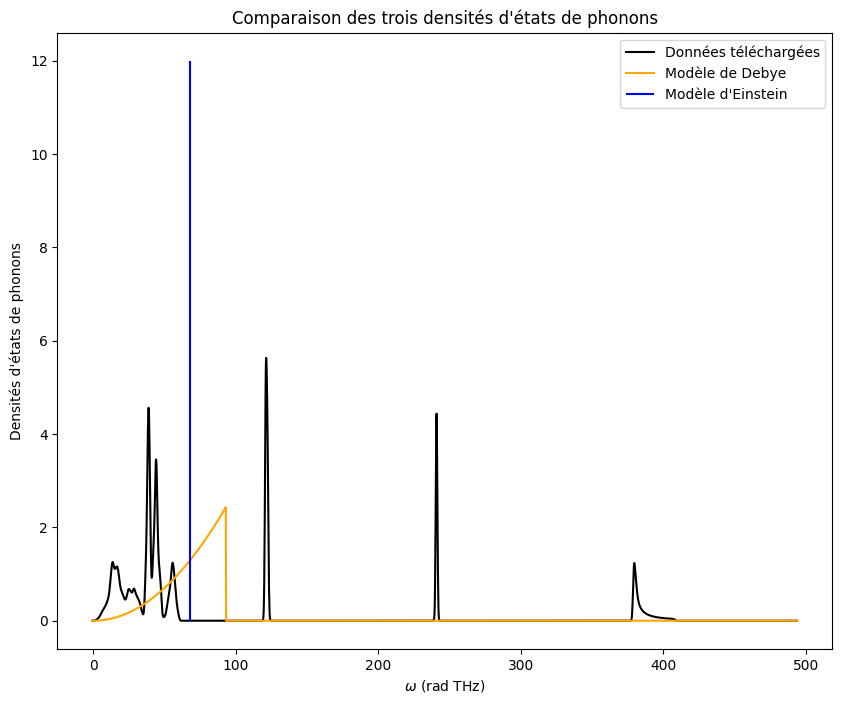

In [16]:
k_B = 1.380649e-23    #J/K
hbar = 1.054e-34  #J.s
frequences = ph_dos.frequencies 
densités = ph_dos.densities

omega_E = (1e-12) * (T_E_optimized * k_B)/hbar   # rad*THz avec 10**12 Hz = THz
omega_D = (1e-12) * (T_D_optimized * k_B)/hbar   # rad*THz avec 10**12 Hz = THz

frequences_E = omega_E/(2*np.pi) #THz
g_E = 3*N_at

reseau_direct = prim_struc.lattice
volume = reseau_direct.volume*10**(-30) #m
q_d = (6*(np.pi**2)/volume)**(1/3) # En 1/m
densités_D = np.zeros(len(frequences))
for i,f in enumerate(frequences):
    omega = 2*np.pi*f
    if omega < omega_D:
        densités_D[i] = 3*N_at*volume*(omega**2)/(2*(np.pi**2)*(omega_D/q_d)**(3))   

plt.figure(figsize=(10, 8))
plt.plot(frequences*2*np.pi, densités , color='black', label="Données téléchargées")
plt.plot(frequences*2*np.pi, densités_D*2*np.pi, color='orange', label="Modèle de Debye")
plt.vlines(frequences_E*2*np.pi, 0, g_E, colors="b", label="Modèle d'Einstein")
plt.ylabel("Densités d'états de phonons")
plt.xlabel('$ \omega$ (rad THz)')
plt.title("Comparaison des trois densités d'états de phonons")
plt.legend()
plt.show()

# Bibliographie
Liens bibliographiques des documents utilisés pour l'ensemble des notebooks.
- Piraux, L., & Rignanese, G.-M. (2025). LMAPR1492 - Physique des Matériaux. Moodle UCLouvain. URL: https://moodle.uclouvain.be/course/view.php?id=856 
- OpenAI. (2025). ChatGPT. URL: https://chat.openai.com​